In [84]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from env import host, user, password
from acquire import get_iris_data
import prepare
import explore

## Acquire Data

- Building out functions I will use to acquire my data and store in my acquire.py for use in my final_report notebook.

In [2]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def new_iris_data():
    '''
    This function reads the iris data from the Codeup db into a df.
    '''
    sql_query = """
                SELECT 
                    s.species_id,
                    s.species_name,
                    m.sepal_length,
                    m.sepal_width,
                    m.petal_length,
                    m.petal_width
                FROM measurements AS m
                JOIN species AS s USING(species_id)
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('iris_db'))
    
    return df

In [4]:
def get_iris_data():
    '''
    This function reads in iris data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('iris_df.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('iris_df.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_iris_data()
        
        # Cache data
        df.to_csv('iris_df.csv')
        
    return df

In [5]:
df = get_iris_data()

In [6]:
df.shape

(150, 6)

In [7]:
df.head()

,species_id,species_name,sepal_length,sepal_width,petal_length,petal_width
0,1,setosa,5.1,3.5,1.4,0.2
1,1,setosa,4.9,3.0,1.4,0.2
2,1,setosa,4.7,3.2,1.3,0.2
3,1,setosa,4.6,3.1,1.5,0.2
4,1,setosa,5.0,3.6,1.4,0.2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   species_id    150 non-null    int64  
 1   species_name  150 non-null    object 
 2   sepal_length  150 non-null    float64
 3   sepal_width   150 non-null    float64
 4   petal_length  150 non-null    float64
 5   petal_width   150 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB


In [9]:
def object_vals(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(df[col].value_counts(dropna=False))

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
species_id,150.0,2.000000,0.819232,1.0,1.0,2.00,3.0,3.0
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [11]:
def col_range(df):
    stats_df = df.describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    return stats_df

In [12]:
# Create a function to summarize my df

def summarize_df(df):
    print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('------------------------')
    print(df.info())
    print('------------------------')
    print(df.head())
    print('------------------------')
    object_vals(df)
    print('------------------------')
    print(col_range(df))

In [13]:
summarize_df(df)

This dataframe has 150 rows and 6 columns.
------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   species_id    150 non-null    int64  
 1   species_name  150 non-null    object 
 2   sepal_length  150 non-null    float64
 3   sepal_width   150 non-null    float64
 4   petal_length  150 non-null    float64
 5   petal_width   150 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB
None
------------------------
   species_id species_name  sepal_length  sepal_width  petal_length  \
0           1       setosa           5.1          3.5           1.4   
1           1       setosa           4.9          3.0           1.4   
2           1       setosa           4.7          3.2           1.3   
3           1       setosa           4.6          3.1           1.5   
4           1       setosa           

## Prepare Data

In [14]:
# Check for Null Values; squeaky clean dataset.
df.isnull().sum()

species_id      0
species_name    0
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
dtype: int64

In [15]:
def num_distributions(df):
    for col in df.columns:
        if df[col].dtype != 'object':
            plt.hist(df[col])
            plt.title(f'Distribution of {col}')
            plt.show()

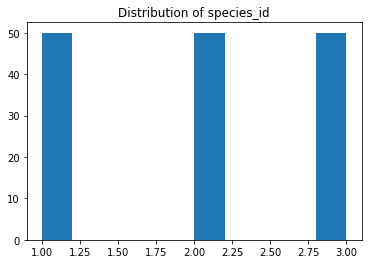

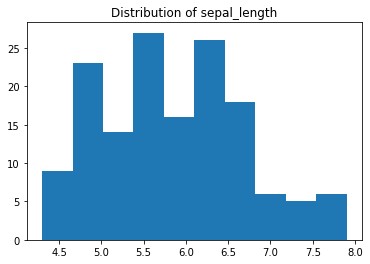

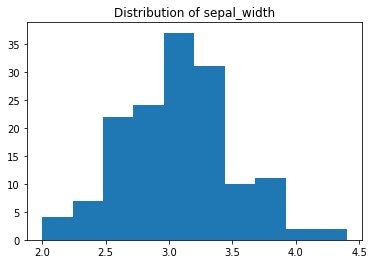

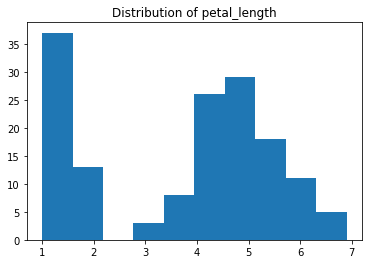

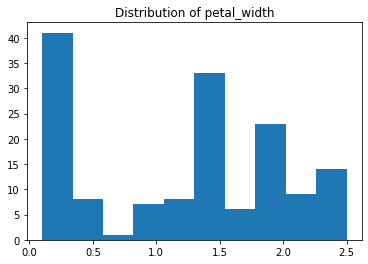

In [16]:
num_distributions(df)

In [17]:
def iris_split(df):
    '''
    This function takes in the iris data acquired by get_iris_data,
    performs a split and stratifies species column.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.species)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.species)
    return train, validate, test

In [18]:
def prep_iris(df):
    '''
    This function takes in the iris df acquired by get_iris_data,
    Drops the species_id column and renames species_name to species, 
    Performs a 3-way split stratified on species, and
    Returns train, validate, and test dataframes.
    '''
    # drop and rename columns
    df = df.drop(columns='species_id').rename(columns={'species_name': 'species'})
    
    # split dataframe into train, validate, and test
    train, validate, test = iris_split(df)
    
    return train, validate, test

In [19]:
train, validate, test = prep_iris(df)

In [20]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (84, 5)
validate -> (36, 5)
test -> (30, 5)


## Explore

In [21]:
plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 10))

In [22]:
# Create melted df for viz
melted = train.melt(id_vars=['species'])

In [23]:
# Check out melted df info.
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   species   336 non-null    object 
 1   variable  336 non-null    object 
 2   value     336 non-null    float64
dtypes: float64(1), object(2)
memory usage: 8.0+ KB


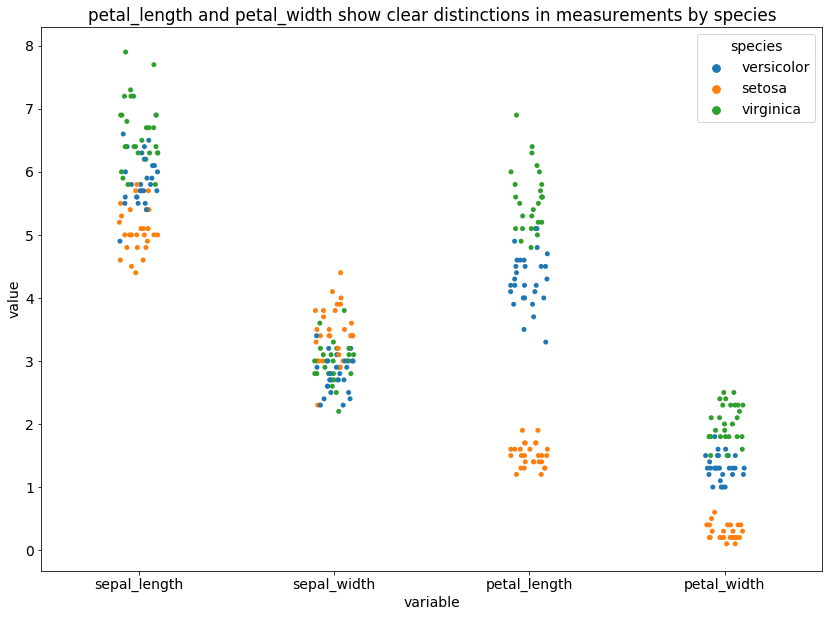

In [24]:
# Create a stripplot to examine the distribution of species throughout each continuous variable.
sns.stripplot(data=melted, x='variable', y='value', hue='species')

plt.title('petal_length and petal_width show clear distinctions in measurements by species')

plt.show()

#### Stripplot Takeaways

- Looking at the distribution of the species throughout each continuous variable, the clear distinctions between petal length and width by species lead me to believe these might be valuable features in predicting species.

In [25]:
# Feature engineering with continuous variables; can I create useful features?

train['sepal_area'] = train.sepal_length * train.sepal_width
train['petal_area'] = train['petal_length'] * train['petal_width']

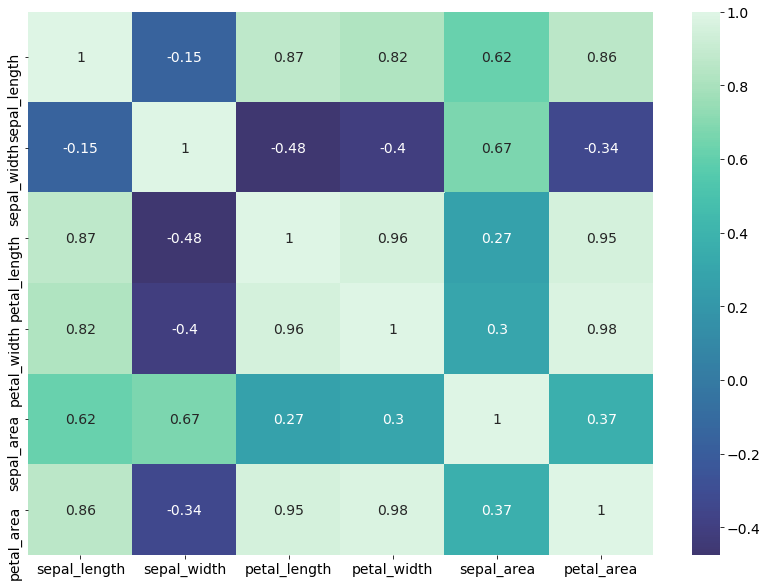

In [26]:
sns.heatmap(train.corr(), cmap='mako', center=0, annot=True)

plt.title('')
plt.show()

##### Heatmap Takeaways

- most measures correlate with each other, the least is sepal_width with sepal_lenght @ -.15.
- Negative correlations: Wider sepals -> shorter & narrower petals (smaller petal areas)
- Positive correlations: Longer sepals -> longer & wider petals (larger petal areas)
- Little to no LINEAR correlation: sepal length & sepal width.

In [27]:
train.head(2)

,species,sepal_length,sepal_width,petal_length,petal_width,sepal_area,petal_area
79,versicolor,5.7,2.6,3.5,1.0,14.82,3.50
36,setosa,5.5,3.5,1.3,0.2,19.25,0.26


In [28]:
combos = [
    ('sepal_length', 'sepal_width'),
    ('petal_length', 'petal_width'),
    ('sepal_area', 'petal_area'),
    ('sepal_length', 'petal_length')
]

In [29]:
def scatter_species(x, y):
    for species, subset in train.groupby('species'):
        plt.scatter(subset[x], subset[y], label=species)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.legend()

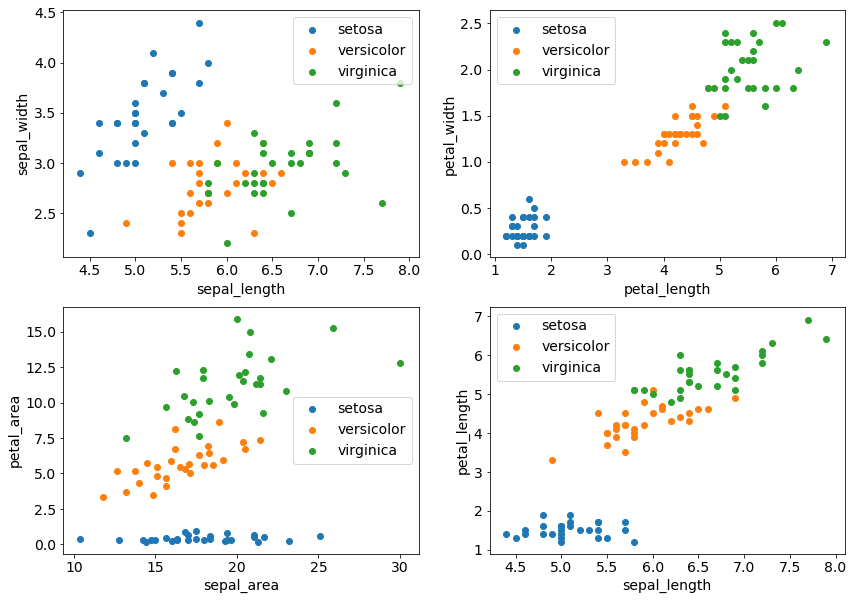

In [30]:
for i, pair in enumerate(combos):
    plt.subplot(2,2,i+1)
    scatter_species(pair[0], pair[1])

##### Feature Engineering Takeaways

- sepal_length is useful, sepal_width not great but likely adds some value.
- petal_area is very useful, as we would expect given the previous plot of petal_width x petal length.
- sepal_area is questionable, as we don't see much separation when we look at the 3rd - plot in a hortizonal direction. Again, some value in sepal width, but not a ton.


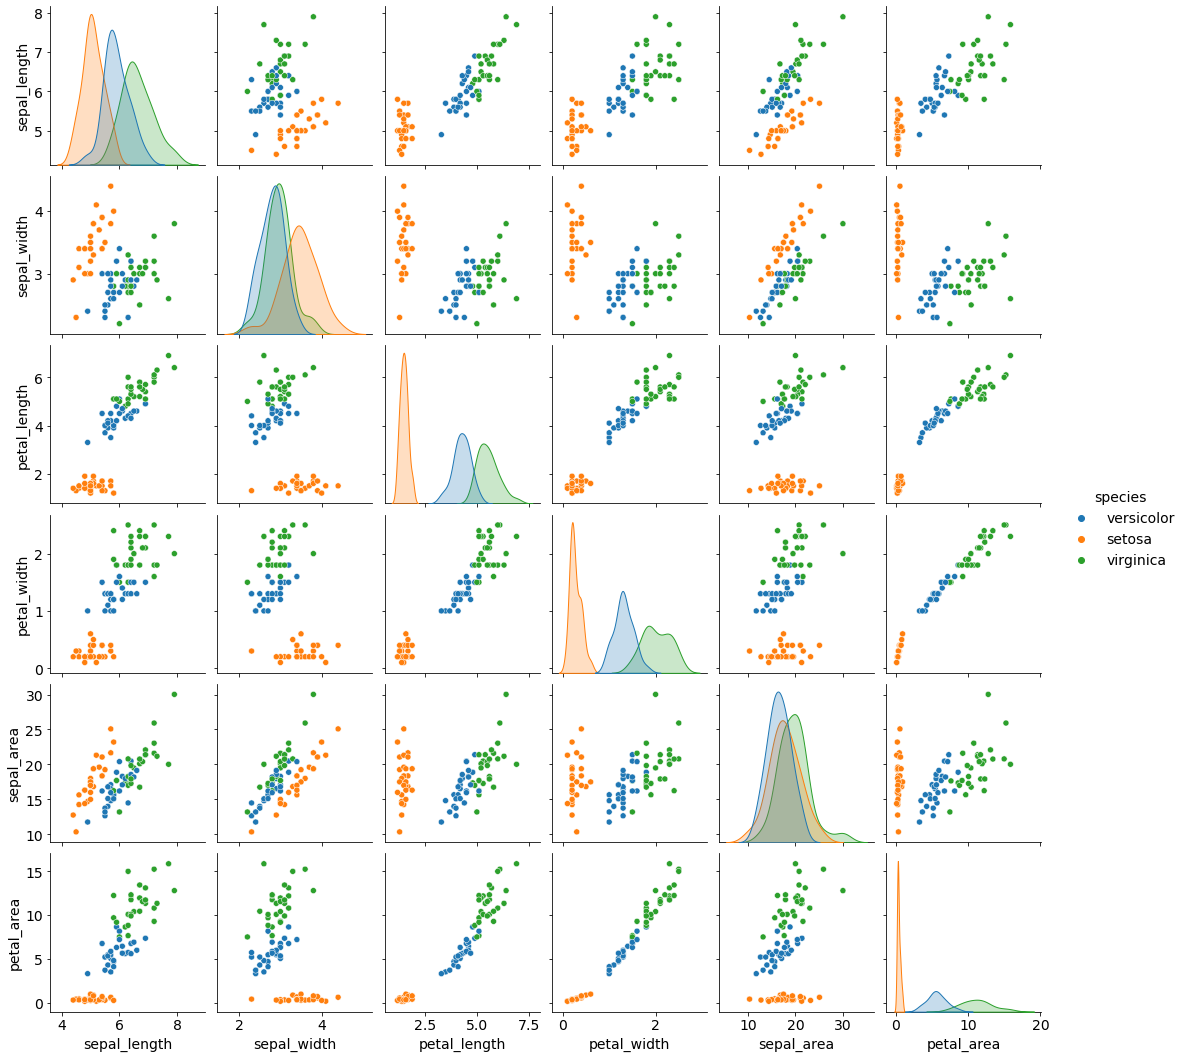

In [31]:
sns.pairplot(train, hue='species')
plt.show()

##### Pairplot Takeaways

- Petal length + petal width show the most seperation between species.
- Setosa has the shortest and narrowest petals. It will be the easiest to determine.
- Petal area seems to show the largest separation between Virginica & Versicolor of all the individual features.
- Virginica shows slightly longer sepals, but whether that difference is significant, it's hard to say.
- Virginica and Versicolor show little to no difference when it comes to the width of the sepals.

##### Statistical Testing

- **Hypothesis 1**

- alpha = .05

- $H_0$: Sepal length is the same in virginica and versicolor. $\mu_{virginica} == \mu_{versicolor}$.  

- $H_a$: Sepal length significantly different in virginica and versicolor. $\mu_{virginica} != \mu_{versicolor}$. 

In [32]:
virginica = train[train['species'] == 'virginica']
versicolor = train[train['species'] == 'versicolor']

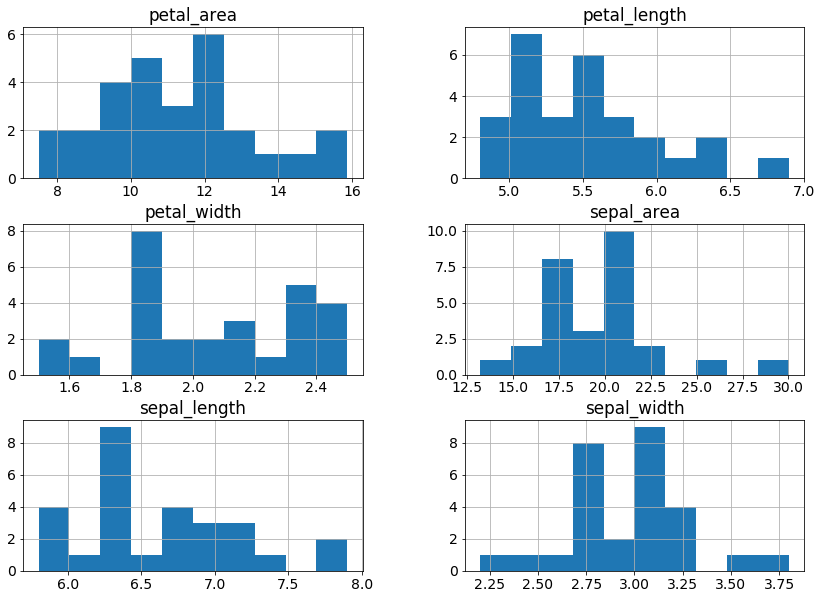

In [33]:
virginica.hist()
plt.show()

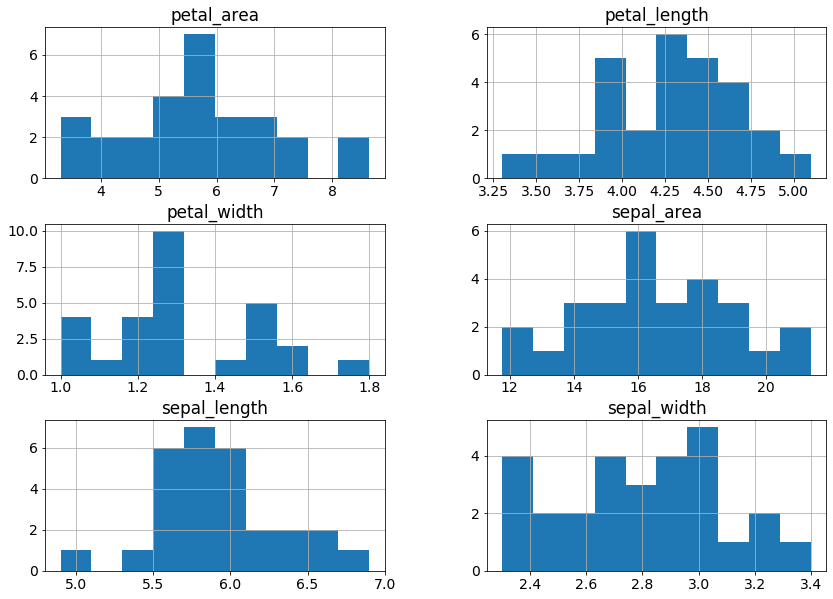

In [34]:
versicolor.hist()
plt.show()

In [35]:
virginica.describe()['sepal_length']['std']

0.5323776159136727

In [36]:
versicolor.describe()['sepal_length']['std']

0.42555596999441053

In [37]:
tstat, p = stats.ttest_ind(virginica.sepal_length,
                versicolor.sepal_length, 
                equal_var=False
               )

In [38]:
tstat

5.656491804882077

In [39]:
p

6.856736413800083e-07

**Conclusion:** Reject the Null; sepal length is not the same in the Virginica and the Versicolor species.

___

**Hypothesis 2**

- alpha = .05

- $H_0$: Sepal width is the same in virginica and versicolor. $\mu_{virginica} == \mu_{versicolor}$.  

- $H_a$: Sepal width significantly different in virginica and versicolor. $\mu_{virginica} != \mu_{versicolor}$. 

In [40]:
stats.mannwhitneyu(virginica.sepal_width, 
                   versicolor.sepal_width
                  )

MannwhitneyuResult(statistic=274.0, pvalue=0.026286295699228482)

**Conclusion:** Reject the Null; sepal width is not the same in the Virginica and Versicolor species.

## Modeling & Evaluating

In [43]:
train.head(1)

,species,sepal_length,sepal_width,petal_length,petal_width,sepal_area,petal_area
79,versicolor,5.7,2.6,3.5,1.0,14.82,3.5


In [44]:
# Define the baseline accuracy: If I predict Versicolor for every observation, 
# my accuracy would be 33%.

train.species.value_counts()

virginica     28
versicolor    28
setosa        28
Name: species, dtype: int64

___

### MVP Model

- I'm going to try a Decision Tree with 
    - `sepal_width`, 
    - `sepal_length`, 
    - `petal_length`,
    - `petal_width` 
- My goal is to beat my 33% baseline accuracy.

In [49]:
# Define X_train.

X_train = train.drop(columns=['species', 'sepal_area', 'petal_area'])
X_train.head(1)

,sepal_length,sepal_width,petal_length,petal_width
79,5.7,2.6,3.5,1.0


In [50]:
# Define X_val and X_test

X_val = validate.drop(columns='species')
X_test = test.drop(columns='species')
X_val.shape, X_test.shape

((36, 4), (30, 4))

In [51]:
# Define y_train

y_train = train.species
y_train.head()

79     versicolor
36         setosa
133     virginica
95     versicolor
18         setosa
Name: species, dtype: object

In [52]:
# Define y_val and y_test

y_val = validate.species
y_test = test.species
y_val.shape, y_test.shape

((36,), (30,))

In [76]:
# Create the dt_model1.

dt_model1 = DecisionTreeClassifier(max_depth=2)

In [77]:
# Fit the model on my X and y train.

dt_model1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [78]:
# Score dt_model1 on train dataset.

dt_model1.score(X_train, y_train)

0.9642857142857143

In [79]:
y_pred_dt_model1 = dt_model1.predict(X_train)

In [80]:
# Print a classification report for train.

print(classification_report(y_train, y_pred_dt_model1))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        28
  versicolor       1.00      0.89      0.94        28
   virginica       0.90      1.00      0.95        28

    accuracy                           0.96        84
   macro avg       0.97      0.96      0.96        84
weighted avg       0.97      0.96      0.96        84



In [81]:
# Score dt_model1 on validate dataset.

dt_model1.score(X_val, y_val)

0.9722222222222222

In [82]:
# Get predictions for validate and print a classifiation report.

y_pred_dt_model1_val = dt_model1.predict(X_val)
print(classification_report(y_val, y_pred_dt_model1_val))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      1.00      0.96        12
   virginica       1.00      0.92      0.96        12

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



### Test Multiple Types of Models

- Create a model.
- Fit to train.
- Score model.

In [134]:
def score_models(X_train, y_train, X_val, y_val):
    '''
    Score multiple models on train and val datasets.
    '''
    lr_model1 = LogisticRegression()
    dt_model1 = DecisionTreeClassifier()
    rf_model1 = RandomForestClassifier()
    kn_model1 = KNeighborsClassifier()
    models = [lr_model1, dt_model1, rf_model1, kn_model1]
    for model in models:
        model.fit(X_train, y_train)
        train_actual = y_train
        train_predicted = model.predict(X_train)
        val_actual = y_val
        val_predicted = model.predict(X_val)
        print(model)
        print('')
        print('train score: ')
        print(classification_report(y_train, train_predicted))
        print('val score: ')
        print(classification_report(y_val, val_predicted))
        print('________________________')
        print('')

In [135]:
score_models(X_train, y_train, X_val, y_val)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

train score: 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        28
  versicolor       1.00      0.96      0.98        28
   virginica       0.97      1.00      0.98        28

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84

val score: 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      1.00      0.96        12
   virginica       1.00      0.92      0.96        12

    accuracy                           0.97     

### Decision Tree with Feature Engineering.



In [46]:
train.head()

,species,sepal_length,sepal_width,petal_length,petal_width,sepal_area,petal_area
79,versicolor,5.7,2.6,3.5,1.0,14.82,3.50
36,setosa,5.5,3.5,1.3,0.2,19.25,0.26
133,virginica,6.3,2.8,5.1,1.5,17.64,7.65
95,versicolor,5.7,3.0,4.2,1.2,17.10,5.04
18,setosa,5.7,3.8,1.7,0.3,21.66,0.51


### Logistic Regression Model

In [ ]:
# Create a simple Logistic Regression model to start.

logit = LogisticRegression(random_state=123)